# Code Availability
This code is written in Python (3.6>) and publicly available. The aim is to provide a custom code to process, visualize and manipulate the SandBoxNL dataset. This statement is included under the heading "Code availability" of the publication: "Sentinel-1 SAR based parcel level crop data in The Netherlands". [Vineet Kumar, Manuel Huber, Bjorn Rommen, and Susan C. Steele-Dunne]

Support:
In the case of any issues or inquiries please contact either:

Vineet Kumar (TU Delft, V.Kumar-1@tudelft.nl), 
Manuel Huber (ESA, ESTEC, manuel.huber@esa.int), 
Susan Steele-Dunne (TU Delft, s.c.steele-dunne@tudelft.nl), 
Björn Rommen (ESA, ESTEC, Bjorn.Rommen@esa.int)

# Abstract and Context: SandBoxNL
Synthetic aperture radar (SAR) data processing, handling and understanding poses significant challenges to both agricultural application specialist and non-expert domain users in the field of agricultural monitoring. Additionally, the data volume of openly available Sentinel-1 SAR requires high-performance local computational facilities to the expert users in operational applications using dense time series of data. To overcome these complexities, we have generated an annual Sentinel-1 SAR database that includes mean and standard deviation of VV, VH and VH/VV backscatter, pixel counts, geometry, crop type, local incidence angle and azimuth angle at parcel-level. The database uses around 1200 Sentinel-1  images to provide time series for approximately 770,000 crop parcels over the Netherlands annually. The database can be queried for Sentinel-1 system parameter (e.g. relative orbit) or user application-specific parameter (e.g. crop type, spatial extent, time period) for individual parcel level assessment or aggregated at administrative boundaries. The database may potentially be useful for agricultural and water related applications in the Netherlands, such as parcel-level crop bio-geophysical parameter estimation, change-detection, inter-annual variability analysis, drought monitoring, grassland monitoring and administrative boundaries based agricultural management decisions.

# Introduction: SandBoxNL Dataset
The annual database consists of spatially averaged VV, VH and VH/VV backscatter values, corresponding standard deviation, viewing incidence angle, local incidence angle, azimuth angle, pixel count and data quality flag for each parcel. Every crop parcel has a unique field ID (OBJECTID), which is used as an index to sort, process, flag and clean the data. Each parcel is stored separately in a data frame containing the time series of all the above-mentioned extracted parameters. This dictionary of all the parcels is stored together with static information in form of a pickle file. Static information includes attributes of the BRP vector data such as parcel geometry, area, centroid, crop type and flag information. As a final step, the pickle.dateset is transformed to a netCDF file to reduce the data size and to provide a universal data format for the scientific user community. Static information about the parcel geometry and crop type is not saved in the netCDF file. The dataset are provided per province and annually.

The following code gives a brief example of how to access, manipulate and visualize the netCDF dataset with Flevoland (2019) as an example. 

In [1]:
"""
 -*- coding: utf-8 -*-
Created on Tue Apr  6 16:05:00 2021
@author: Manuel Huber (ESA, ESTEC: manuel.huber@esa.int)
"""

import netCDF4 as nc4
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import pickle as pickle
import xlrd
from datetime import datetime, date, time
import glob
import math    
import os
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely import wkt
import shapely

In [2]:
# Reading the data.... 
# Example for one province in 2018

# Path of netCDF datasets (per province)
path = 'C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/NetCDF Final 2018/'

# Selecting one province as example... 
fh = Dataset('{}Prov_Flevoland.nc'.format(path), mode='r')

# Selecting and loading PDOK shp files for geometry and crop description...
#fields = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/April_2020/BRP_2019_proj/BRP_Proj_2019.shp') 
fields = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/April_2020/BRP_2018_proj/BRP_2018_proj')
#fields = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/April_2020/BRP_2017_proj/BRP_2017_proj')

municipality_all = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/gemme_2018_proj/gem_2018_proj.shp')

province_all = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/Province_Netherlands_Proj/Province_Netherlands_Proj/Province_van_nederland_proj.shp')

# Find crop types from BRP parcel name list.
The Basisregestratie GewasPercelen (BRP, Base Crop Parcel Register) shape filescontains parcel name information in Dutch. To extract the information about theparticular parcel or crop type user needs to input/query the database in Dutch. Hence to assist crop type information, we have provided the following list detailsthe corresponding crop name in English  ("BRP_Parcel_Name_list_dutsch_english_2019") . 

User needs to input exact name of crop in Dutch language including the special characters (Example: Aardappelen, bestrijdingsmaatregel AM). These following list is created by using BRP 2019 data. Specifically Maize crop has a special character in the BRP-2019 shape files,(Ma�s, snij-). So, user should carefully input while calling 2019 maize cropdatabase. For 2017 and 2018 Maize crop can be called with actual Dutchword (Maïs) for it.

The following code should help to select the correct dutch crop names. Two functions are implemented to either find the corresponding names using either a english crop name or starting letter. In total 312 different crops are prese

In [4]:
# Loading the excel sheet, which contains the dutch and english description of the crop types
translate = pd.read_excel('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/BRP Translation/Translation_List_Dutch_English_Crop_Names_2019.xlsx')
translate.index = translate['Crop_Number'].astype(int)  # The crop number refers to the 'GWS_GEWASC' number of the BRP/Fields files
del translate['Crop_Number']

# Function to find all descriptive names (dutch and englisch) for a given crop name/type (given in englisch)
def find_crop_names_per_name(mystring):
    index = []
    for i in range(len(translate)):
        cell = translate['Crop name (English)'].iloc[i]
        if mystring in cell:
            index.append(i)
    return translate.iloc[index]

# Function to find crops with starting letter of the crop name/type (serach in english)
def find_crop_names_per_letter(myletter):
    index = []
    for i in range(len(translate)):
        cell = translate['Crop name (English)'].iloc[i]
        if myletter in cell[0]:
            index.append(i)
    return translate.iloc[index]

# Two examples on how to use the above functions:
example1 = find_crop_names_per_name("Potatoes") # Input must be in english. Sometimes 
                                                # Crops are given in plural or small/big captial starting letter
                                                # If this does not help please search manually in the trasnlation list
print('Output for search using an english name:','\n',example1)


# If it is not possible to find the crop using the full name try to search for the starting letter:
example2 = find_crop_names_per_letter("W") # Input must be in in engish and capital (sometimes large or small)
print('Output for search using a letter:','\n',example2)


Output for search using an english name: 
                                            Crop name (English)  \
Crop_Number                                                      
2014                                      Potatoes consumption   
2015             Potatoes seeds other than for starch potatoes   
2016                        Potatoes seeds for starch potatoes   
2017                                          Potatoes, starch   
2025         Potatoes, control measures for Aardappelmoehei...   

                                 Crop name (Dutch)  
Crop_Number                                         
2014                       Aardappelen, consumptie  
2015                         Aardappelen, poot NAK  
2016                         Aardappelen, poot TBM  
2017                          Aardappelen, zetmeel  
2025         Aardappelen, bestrijdingsmaatregel AM  
Output for search using a letter: 
                                         Crop name (English)  \
Crop_Number             

In [5]:
# Getting list of variables stored in the netCDF

# Keys for time variable data (Parcel x Time)
keys_data = list(fh['Data'].variables.keys())
# Keys for static data (Parcel)
keys_ID = list(fh['Parcel_ID'].variables.keys())

print('Variables:' ,'\n', keys_data)
print('Static Information per ID:' ,'\n',keys_ID)


Variables: 
 ['vv_mean', 'vv_std', 'vh_mean', 'vh_std', 'CR_mean', 'CR_std', 'lia', 'ea', 'aza', 'OID', 'pix', 'MID', 'RO', 'time_num']
Static Information per ID: 
 ['ID', 'lon', 'lat', 'flag_37', 'flag_88', 'flag_15', 'flag_161', 'flag_110']


# Structuring the data
Data can be directly used from the netCDF file. However, due to data handling I recommend using pandas or similiar dataframe libaries to further process the data. In this example pandas is used.
 
The structure of the netCDF is per ObjectIDs for example:

fh['Data']['vv_mean'][:,:].data - Gives the VV (mean) backscatter for all parcels and time [Parcel:Time]
fh['Parcel_ID']['ID'][:].data  - Gvies the ObjectIDs of all parcels

In [6]:
# Load static data in a pandas dataframe per field ID:

df_ID = pd.DataFrame()
for i in range(len(keys_ID)):
    df_ID['{}'.format(keys_ID[i])] = fh['Parcel_ID'][keys_ID[i]][:].data 

# Combine static information with field information to one dataframe
fields.index = fields.OBJECTID.astype(int)
df_ID.index = df_ID.ID
fields_sel = fields[fields.index.isin(df_ID.index)] # Select only field IDs which are represented in the loaded data


df_ID_all = pd.concat([df_ID,fields_sel],axis=1) # Combine field information with static parcel information into one dataframe

print(df_ID_all.info(), df_ID_all.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16387 entries, 1526214 to 2300881
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          16387 non-null  int32   
 1   lon         16387 non-null  float32 
 2   lat         16387 non-null  float32 
 3   flag_37     16383 non-null  float32 
 4   flag_88     16382 non-null  float32 
 5   flag_15     7804 non-null   float32 
 6   flag_161    1803 non-null   float32 
 7   flag_110    16304 non-null  float32 
 8   OBJECTID    16387 non-null  int64   
 9   CAT_GEWASC  16387 non-null  object  
 10  GWS_GEWASC  16387 non-null  object  
 11  GEOMETRIE_  16387 non-null  float64 
 12  GEOMETRIE1  16387 non-null  float64 
 13  GWS_GEWAS   16387 non-null  object  
 14  geometry    16387 non-null  geometry
dtypes: float32(7), float64(2), geometry(1), int32(1), int64(1), object(3)
memory usage: 1.5+ MB
None               ID       lon        lat  flag_37  flag_88  flag_15  f

In [7]:
# Function to extract time series data per variable and per parcel.

def get_data_from_netcdf(netCDF, key):
    data_all = netCDF['Data']['{}'.format(key)][:,:].data # Key is the selected variable
    mask = netCDF['Data']['{}'.format(key)][:,:].mask
    data_mask =[]
    for i in range(len(data_all)):
        data_mask.append(data_all[i][~mask[i]])        

    return data_mask

In [8]:
# Function to transform the time 
def transform_time(data):
    calendar = 'gregorian' # Time is transfromed to gregorian time in the netCDF 
    units = 'hours since 1900-01-01 00:00:00.0'
    
    time = [pd.to_datetime(nc4.num2date(data.iloc[ls], units = units, calendar = calendar).astype(str), format='%Y-%m-%d %H:%M:%S') for ls in range(len(data))]
    return time

In [9]:
# Load time series data:
      
keys_data = ['vv_mean', 'vh_mean','RO','time_num']  # Selection of variables for further analysis

df_data_all = pd.DataFrame() # Creating a dataframe at which all variables of a unique parcel will be stored.

for i in range(len(keys_data)):
    df_data_all['{}'.format(keys_data[i])]=get_data_from_netcdf(fh, keys_data[i])    

df_data_all.index = df_ID.ID # Put ObjectIDs as index 

# Transform the gregorian time to the actually time stamps
date_time_all = pd.DataFrame(transform_time(df_data_all.time_num))
date_time_all.index = df_data_all.index

print(df_data_all.head())

                                                   vv_mean  \
ID                                                           
1526214  [0.13317446, 0.0831083, 0.11222746, 0.11465305...   
1526403  [0.528971, 0.4545873, 0.5456623, 0.4571521, 0....   
1526456  [0.13448438, 0.1903763, 0.063411176, 0.0838248...   
1526457  [0.36455506, 0.24779654, 0.28487408, 0.3392822...   
1526495  [0.30363277, 0.20596045, 0.15277292, 0.1990689...   

                                                   vh_mean  \
ID                                                           
1526214  [0.032507993, 0.021044848, 0.026347155, 0.0178...   
1526403  [0.08373972, 0.071390055, 0.07288147, 0.068500...   
1526456  [0.04401792, 0.018522637, 0.025890896, 0.02903...   
1526457  [0.04932441, 0.042864166, 0.05589017, 0.054263...   
1526495  [0.031068126, 0.0237239, 0.020836178, 0.020660...   

                                                        RO  \
ID                                                           
152621

In [10]:
# Get the units and describtions: 
    
units = []
descrp = []

for i in range(len(keys_data)):
    units.append(fh['Data']['{}'.format(keys_data[i])].unit)
    descrp.append(fh['Data']['{}'.format(keys_data[i])].long_name)
    
    
print('Units' +'\n',units)
print('Descriptions' +'\n',descrp)

Units
 ['Linear backscatter intensity', 'Linear backscatter intensity', '[-]', 'hours since 1900-01-01 00:00:00.0']
Descriptions
 ['Linear backscatter intensity VV mean - 0', 'Linear backscatter intensity VH mean - 2', 'Relavtive Orbit - 12', '[calendar = gregorian; units = hours since 1900-01-01 00:00:00.0]']


# OBJECTIDs (Parcel) selection at various scale

1) All IDs which were given manual from Lon/Lat combinations 2) All IDs within a given municipality 3) All IDs within the province

#User need to run this cell only if they want to make parcel selection from manually input lat/long values

# Selecting ObjectIDs and field information depending on longitude and latitude

This is necessary for users, who have a list of longitudes and latitudes and want to select the fields according to those. This can be done using the fields polygons (provided by PDOK). The polygons are selected on the bases that the lon-lat combination (point) is within the outlined polygon. This means that the points must be in the boundary of the parcel in order to be identified. Again, it is to mention that the field locations change per year, which makes it important to always select the correct shapefile. Furthermore, it is important to have loaded the correct netCDF file to match the objectIDs.  

In the following example, points where selected in the Flevoland province.


Int64Index([1982499, 1560970, 1903813, 2103386, 2153593, 2029705, 1899505,
            1558368, 1903812, 2077497, 1716849, 2169741, 2087039, 1555069],
           dtype='int64', name='OBJECTID')


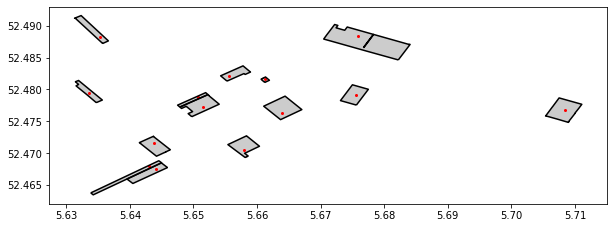

In [11]:
# List of points (this can be integrated by uploading a csv file - in case a lat-lon list exists already)
list_lon_lat = [
    [5.675902485185551,52.48838138537458],
    [5.663843273454594,52.47630669355332],
    [5.655646442705082,52.482083095990625],
    [5.70838940077393,52.476829476115576],
    [5.675602077775883,52.47918192078341],
    [5.651483654313969,52.47722155896118],
    [5.657878040605473,52.470477247257],
    [5.643801807695317,52.47157522890128],
    [5.661268352800297,52.48156037584885],
    [5.650754093461918,52.47884213099183],
    [5.635304569536137,52.48827685681074],
    [5.633502125078129,52.47949557056959],
    [5.642943500810551,52.467889039283634],
    [5.644059299760746,52.46754916228505]
    ]
# Create a geocoded points
df_points = [Point(list_lon_lat[i][0], list_lon_lat[i][1]) for i in range(len(list_lon_lat))]

# Function to extract the polygon for each field in the list
def get_id_per_lon_lat(list_lon_lat, fields):
    ls_points = []
    for i in range(len(list_lon_lat)):                   
        point = Point(list_lon_lat[i][0], list_lon_lat[i][1])
        ls_points.append(fields[fields.geometry.contains(point)])
    return pd.concat(ls_points)

lst_polygons = get_id_per_lon_lat(list_lon_lat, fields) # Apply function *fields = PDOK shapefile
selected_poly  = lst_polygons[lst_polygons.OBJECTID.isin(fh['Parcel_ID']['ID'][:].data)] # Check if the selected fields are in the netCDF dataset
# Plotting the selected parcels for the given points
fig,ax= plt.subplots(figsize=(10,4))
gpd.GeoDataFrame(selected_poly, geometry='geometry').plot(ax =ax, color='grey', alpha = 0.4,  missing_kwds={"edgecolor": "red"}) # Corresponding polygons
gpd.GeoDataFrame(selected_poly, geometry='geometry').boundary.plot(ax =ax, markersize=2, color='black')
gpd.GeoDataFrame(df_points, geometry=df_points).plot(ax =ax, markersize=4,color= 'red') # Points selected by user

selected_IDs = selected_poly.index # This gives a list OBJECTIDs corresponding to the selected fields.
print(selected_IDs)

#  Select parcels within a municipality boundary
In order to work municipality wise the following code provide you an example to generate a list of OBJECTIDs which are associated to a given municipality within the loaded province. 
#Run next two cells if user wants to work with municipality administrative layer

In [12]:
# List  all municipalities within the loaded province (example)
prov = 'Flevoland'
selected_prov = province_all[province_all.PROV_NAAM == prov].iloc[0]

municipalities = []

for i in range(len(municipality_all)):
    point = shapely.wkt.loads(municipality_all.iloc[i].geometry.centroid.wkt)
    if selected_prov.geometry.contains(point):
        municipalities.append(municipality_all.iloc[i])
municipalities = pd.concat(municipalities, axis =1).T 
print('All municipalities within the loaded province: ', municipalities.GM_NAAM.values)

All municipalities within the loaded province:  ['Almere' 'Zeewolde' 'Noordoostpolder' 'Urk' 'Dronten' 'Lelystad']


In [13]:
#This example extracts all field IDs for Dronten municipality of Flevoland province.

municipality = 'Dronten'

def get_id_per_muncip(municipality, df_ID):
    select = municipality_all[municipality_all['GM_NAAM']== municipality]
    ls_points = []
    for i in range(len(df_ID)):                   
        point = Point(df_ID.lon.iloc[i], df_ID.lat.iloc[i])
        if select.iloc[0].geometry.contains(point)==True:
            ls_points.append(df_ID.iloc[i])
    return pd.concat(ls_points, axis = 1).T

df_per_municipality = get_id_per_muncip(municipality, df_ID_all) # List of parcel infomation for all fieds within the municipality
df_per_municipality.head() 

,ID,lon,lat,flag_37,flag_88,flag_15,flag_161,flag_110,OBJECTID,CAT_GEWASC,GWS_GEWASC,GEOMETRIE_,GEOMETRIE1,GWS_GEWAS,geometry
1526403,1526403,5.65258,52.4902,0,0,NaN,NaN,0,1526403,Bouwland,2014,1088.92,74017,"Aardappelen, consumptie","POLYGON ((5.652039460647789 52.48852572106463,..."
1527017,1527017,5.70035,52.5058,0,0,NaN,NaN,0,1527017,Bouwland,258,509.038,9643.99,Luzerne,"POLYGON ((5.700600026323468 52.5051040847348, ..."
1531238,1531238,5.74182,52.5332,0,0,0,NaN,0,1531238,Bouwland,233,941.78,52296.6,"Tarwe, winter-","POLYGON ((5.743653852645989 52.53211649353052,..."
1532220,1532220,5.65076,52.5584,0,0,NaN,NaN,0,1532220,Bouwland,2025,1025.65,14973.7,"Aardappelen, bestrijdingsmaatregel AM","POLYGON ((5.653745336722294 52.55702319263321,..."
1532504,1532504,5.64472,52.5772,0,0,NaN,NaN,0,1532504,Bouwland,2015,1346.23,103757,"Aardappelen, poot NAK","POLYGON ((5.644237956547349 52.57494488652407,..."


# Selecting processing IDs

In this section you can choose which IDs you want to use for the further analysis. So far there are three options:

1) All IDs which were given manual from Lon/Lat combinations
2) All IDs within a given municipality
3) All IDs within the province 

Please activate desired ID list in the following code lines: By default code will run for province layer 

In [14]:
# ----- IDs per given Lon/Lats: ------#
#df_data = df_data_all[df_data_all.index.isin(selected_IDs)]
#date_time = date_time_all[date_time_all.index.isin(selected_IDs)]
#df_ID = df_ID_all[df_ID_all.index.isin(selected_IDs.values)]
#print('IDs per given Lon/Lats', df_ID.head())

# ----- IDs per given municipality:  ------#
#df_data = df_data_all[df_data_all.index.isin(df_per_municipality.index)]
#date_time = date_time_all[date_time_all.index.isin(df_per_municipality.index)]
#df_ID = df_ID_all[df_ID_all.index.isin(df_per_municipality.index)]
#print('IDs per given municipality', df_ID.head())

# ----- IDs per given province:  ------#
df_data = df_data_all
date_time = date_time_all
df_ID = df_ID_all
print('IDs per province', df_ID.head())

IDs per province               ID       lon        lat  flag_37  flag_88  flag_15  flag_161  \
1526214  1526214  5.663548  52.712864      0.0      0.0      2.0       NaN   
1526403  1526403  5.652577  52.490215      0.0      0.0      NaN       NaN   
1526456  1526456  5.748034  52.766430      0.0      0.0      0.0       NaN   
1526457  1526457  5.767463  52.761814      0.0      0.0      0.0       NaN   
1526495  1526495  5.818663  52.718090      0.0      0.0      0.0       NaN   

         flag_110  OBJECTID CAT_GEWASC GWS_GEWASC   GEOMETRIE_    GEOMETRIE1  \
1526214       0.0   1526214   Bouwland       2015   583.773774  19567.658998   
1526403       0.0   1526403   Bouwland       2014  1088.916805  74017.000148   
1526456       0.0   1526456   Grasland        265   251.156055   2383.092668   
1526457       0.0   1526457   Bouwland        262   681.453720  27005.621674   
1526495       0.0   1526495   Bouwland        233   977.315692  57508.883191   

                       GWS_GEWAS 

# Plotting time series for an example field

Here the static information can be used to select specific parcels. For example, certain crop types, parcels without flags, specific lon and lat etc. 

The data is still in linear scale, hence needs to be scaled to dB with math.log10(y)*10. 

NOTE: Plotting the time series without further selection gives all backscatter values for ALL orbits. If one is interested in a single orbit or desc./asc. it is necessary to select the orbits of interest beforehand.

                      vv_mean   vh_mean   RO
1526214                                     
2018-01-01 05:56:15  0.133174  0.032508  110
2018-01-02 05:48:45  0.083108  0.021045   37
2018-01-05 17:26:15  0.112227  0.026347   88
2018-01-07 05:56:15  0.114653  0.017805  110
2018-01-08 05:48:45  0.032432  0.009113   37


Text(0.5, 1.0, '1526214 - Orbit 88')

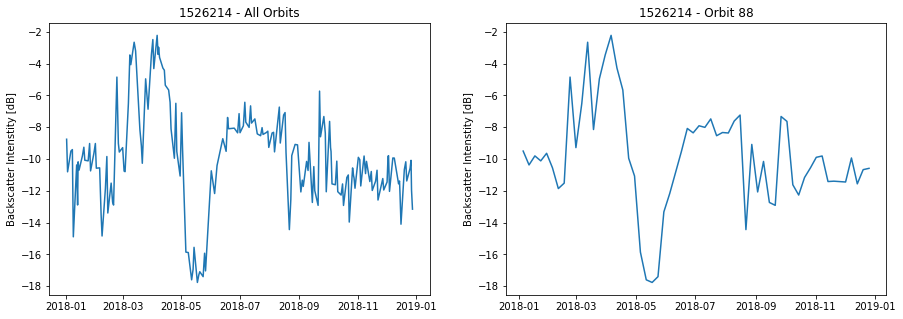

In [15]:
# First Plotting time series.... Comparing backscatter signal from all orbits to one orbit:
'''
Variables: 
 ['vv_mean', 'vv_std', 'vh_mean', 'vh_std', 'CR_mean', 'CR_std', 'lia', 'ea', 'aza', 'OID', 'pix', 'MID', 'RO', 'time_num']

These can be used as a vector or directly as a string.

'''

# Example selection of the first field in the dataframe
field = 0  

df_plot = pd.DataFrame()
for i in range(len(keys_data)-1):
    df_plot[keys_data[i]] = df_data[keys_data[i]].iloc[field]
df_plot.index =   date_time.iloc[field].dropna()                    

print(df_plot.head())


# Plotting vv mean backscatter
var = 0      # 0 represents vv_mean in the variable space - keys_data[i]
var_db = [math.log10(y)*10 for y in df_plot[keys_data[var]]] # Selection of variable and transfromation the signal to dB


fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(df_plot.index, var_db)
plt.ylabel('Backscatter Intenstity [dB]')
plt.title('{} - All Orbits'.format(df_ID['ID'].iloc[field]))

df_plot88 = df_plot[df_plot.RO == 88]
var_db88 = [math.log10(y)*10 for y in df_plot88[keys_data[var]]] # Selection of variable and transfromation the signal to dB

plt.subplot(1,2,2)
plt.plot(df_plot88.index, var_db88)
plt.ylabel('Backscatter Intenstity [dB]')
plt.title('{} - Orbit 88'.format(df_ID['ID'].iloc[field]))

# Plotting time series for a certain crop type


In [16]:
# Plotting certain crop type variation

# 1) Get list of all crop types

list_crops = df_ID['GWS_GEWAS']
print(list_crops)

# 2) Get Object IDs for certain crop type using field data (PDOK)) 

crop_string = list_crops.iloc[0] #  Or you can insert a string manually 'Aardappelen, consumptie'
crop = df_ID[df_ID['GWS_GEWAS']==crop_string] 

print('Following example crop is:',crop_string, ' - Length Parcels: ', len(crop))

1526214      Aardappelen, poot NAK
1526403    Aardappelen, consumptie
1526456         Grasland, blijvend
1526457                Uien, zaai-
1526495             Tarwe, winter-
                    ...           
2300816             Tarwe, winter-
2300826        Spinazie, productie
2300840      Aardappelen, poot NAK
2300860        Grasland, tijdelijk
2300881            Bieten, suiker-
Name: GWS_GEWAS, Length: 16387, dtype: object
Following example crop is: Aardappelen, poot NAK  - Length Parcels:  1637


In [17]:
# 2) Selecting data depending on the crop object IDs and orbit

# List of ObjectIDs
IDs = crop.index

# Choose Orbit
orbit = 88

data_crop = df_data[df_data.index.isin(IDs)]
date_time_crop = date_time[date_time.index.isin(IDs)]

df_crop = []

for field in range(len(IDs)):
    df_plot = pd.DataFrame()

    for i in range(len(keys_data)-1): # For all variables...
        df_plot[keys_data[i]] = data_crop[keys_data[i]].iloc[field]
    df_plot.index =   date_time_crop.iloc[field].dropna()  
    df_crop.append(df_plot[df_plot.RO ==orbit])


print(df_crop[0].head())

                      vv_mean   vh_mean  RO
1526214                                    
2018-01-05 17:26:15  0.112227  0.026347  88
2018-01-11 17:26:15  0.091823  0.020105  88
2018-01-17 17:26:15  0.104639  0.019315  88
2018-01-23 17:26:15  0.097378  0.023949  88
2018-01-29 17:26:15  0.108672  0.023976  88


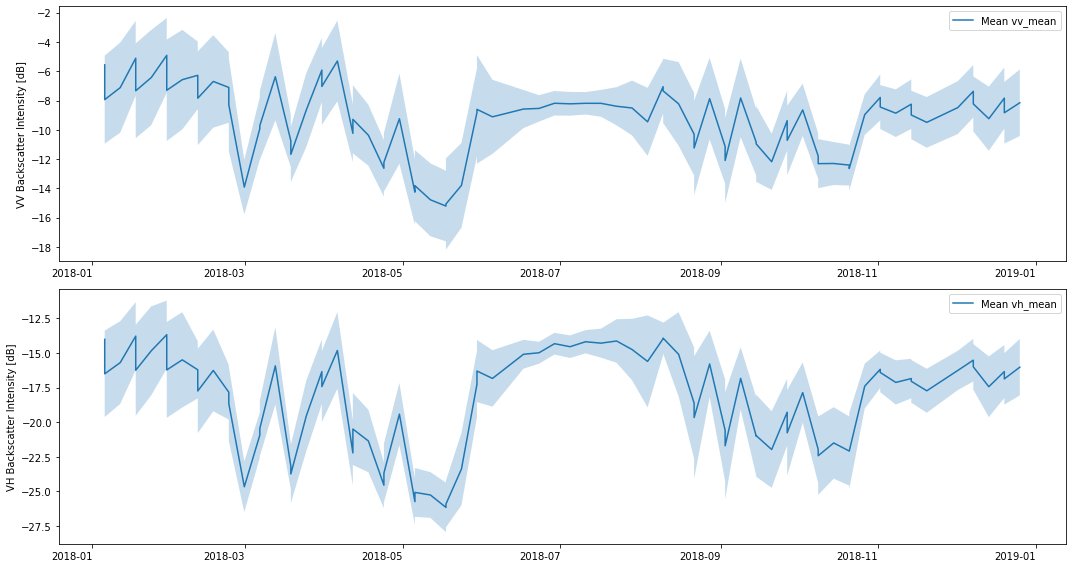

In [18]:
# 3) Plotting mean and variation of multiple crops within the parcel selection (Considering one Orbit)

# Function to calculate mean and std per field in a object ID selection
def get_std_mean_for_var(data, var):
    if len(data) <=1:
        print('There are too little fields to plot the mean and standard variation; Please select more parcels.')
    else:
        data_db = pd.concat(data, axis=1)
        data_db = data_db[var].applymap(lambda x: math.log10(x)*10)
        mean = data_db.T.mean()
        std = data_db.T.std()
    return [mean, std]

vv = get_std_mean_for_var(df_crop, 'vv_mean')
vh = get_std_mean_for_var(df_crop,'vh_mean')

fig,ax= plt.subplots(figsize=(15,8))

plt.subplot(2,1,1)
var = vv
ax = var[0].plot(label = 'Mean {}'.format(keys_data[0]))
ax.fill_between(var[0].index,  var[0] -  var[1],  var[0] +  var[1],
                alpha=.25)
ax.tick_params(axis='x', labelrotation=0 )
ax.set_ylabel("VV Backscatter Intensity [dB]")
plt.legend()

plt.subplot(2,1,2)
var = vh
ax = var[0].plot(label = 'Mean {}'.format(keys_data[1]))
ax.fill_between(var[0].index,  var[0] -  var[1],  var[0] +  var[1],
                alpha=.25)
ax.tick_params(axis='x', labelrotation=0 )
ax.set_ylabel("VH Backscatter Intensity [dB]")
plt.legend()

plt.tight_layout()

# Plotting spatial plots for a specific time step

In the fields (shapefile) the geometries are available to plot the field outlines. Filling these fields with colormaps depending on certain variables gives a good illustration of the spatial value distribution for a certain time step. 

In [19]:
# Get date and create dateframe per time step for all fields
time_uni =np.unique(date_time.T.dropna().astype(str))
print('Length unique timesteps: ', len(time_uni))
# Example time step
dates = pd.to_datetime(time_uni).date
time_sel = dates[60] # Select random date as an example 
time_sel 

geo_df = []
IDs_sel = []


for field in range(len(df_ID)):
    df_plot = pd.DataFrame()

    for i in range(len(keys_data)-1): # For all variables...
        df_plot[keys_data[i]] = df_data[keys_data[i]].iloc[field]
    df_plot.index =  date_time.iloc[field].dropna()
    df_plot = df_plot[df_plot.index.date == time_sel]
    if len(df_plot)!= 0:
        geo_df.append(df_plot)
        IDs_sel.append(df_ID.index[field])
geo_df = pd.concat(geo_df)
geo_df.index = IDs_sel


print(geo_df.head())

Length unique timesteps:  196
          vv_mean   vh_mean   RO
1526214  0.083958  0.007173  110
1526403  0.043000  0.004107  110
1526456  0.063707  0.007353  110
1526457  0.061754  0.003231  110
1526495  0.023518  0.002523  110


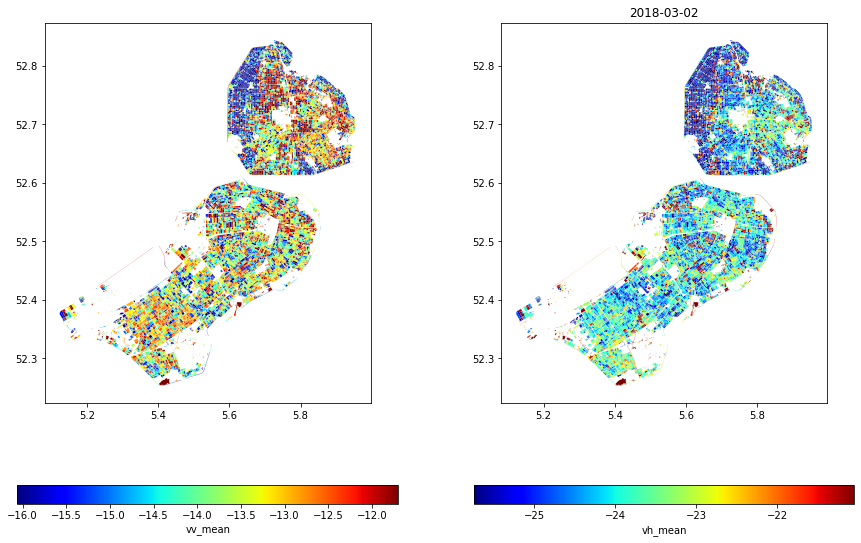

In [20]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))

geo_plot = gpd.GeoDataFrame(df_ID[df_ID.index.isin(geo_df.index)], geometry='geometry')   # Create geopandas dataframe for the selected object IDs
#Plotting all three variables... 
var =['vv_mean', 'vh_mean']
axes =[ax1, ax2]
for i in range(len(var)): # Plotting it for VV and VH backscatter
        geo_plot[var[i]]= [math.log10(y)*10 for y in geo_df[var[i]].values] # Transforming the backscatter into dB
        gpd.GeoDataFrame(geo_plot, geometry='geometry').plot(ax =axes[i],column = var[i], cmap ='jet', legend=True, vmin =np.percentile(geo_plot[var[i]],10), vmax =np.percentile(geo_plot[var[i]],90),legend_kwds={'label': var[i], 'orientation': "horizontal"})
        plt.title(time_sel)